In [411]:
# import numpy as np
import pandas as pd
from debugpy.common.timestamp import current
from nltk import precision
from xgboost.dask import predict

In [412]:
df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1')

In [413]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4541,spam,FreeMsg Hi baby wow just got a new cam moby. W...,NaN,NaN,NaN
1094,ham,Now only i reached home. . . I am very tired n...,NaN,NaN,NaN
2669,spam,we tried to contact you re your response to ou...,NaN,NaN,NaN
5000,ham,"Nope. Since ayo travelled, he has forgotten hi...",NaN,NaN,NaN
2012,ham,Beautiful Truth against Gravity.. Read careful...,NaN,NaN,NaN


In [414]:
df.shape

(5572, 5)

1. Data Cleaning
2. EDA
3. Text Preprocessing
4. Model Building
5. Evaluation
6. Improvement
7. Website
8. Deploy

# 1. Data Cleaning


In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [416]:
# drop last 3 cols
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [417]:
df.sample(5)

,v1,v2
599,ham,I'm going out to buy mum's present ar.
1500,ham,Host-based IDPS for linux systems.
4563,ham,Tell me again what your address is
602,ham,Speaking of does he have any cash yet?
2138,ham,K still are you loving me.


# Renaming the columns

In [418]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.sample(5)

,target,text
4720,ham,"Yup. Anything lor, if u dun wan it's ok..."
3450,ham,Yes we were outside for like 2 hours. And I ca...
5556,ham,Yes i have. So that's why u texted. Pshew...mi...
2194,ham,Hi my email address has changed now it is
2143,ham,You stayin out of trouble stranger!!saw Dave t...


In [419]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [420]:
df['target'] = encoder.fit_transform(df['target'])

In [421]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Missing values

In [422]:
df.isnull().sum()

target    0
text      0
dtype: int64

# Check for duplicate values

In [423]:
df.duplicated().sum()

np.int64(403)

# Remove duplicates

In [424]:
df = df.drop_duplicates(keep='first')

In [425]:
df.duplicated().sum()

np.int64(0)

In [426]:
df.shape

(5169, 2)

# 2. EDA

Розвідувальний аналіз даних (РАД) - це спосіб оцінювання наборів даних з метою виокремлення їхніх суттєвих властивостей, як правило, з використанням візуальних підходів.

In [427]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [428]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Бачимо, що кількість емейлів без спаму 4516, а з спамом - 653

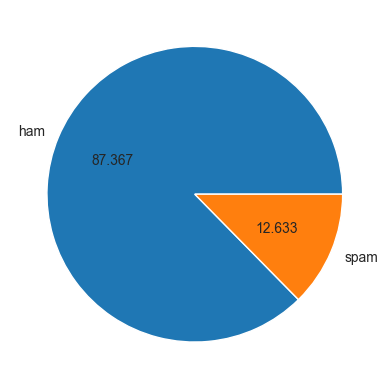

In [429]:
import matplotlib.pyplot as plt

plt.pie(df['target'].value_counts(), labels=["ham", "spam"], autopct='%0.3f')
plt.show()

Бачимо по пайчарту, що 87.367% емейлів без спаму, а з спамом - 12.633%.

Але маємо імбаланс даних (трошки)

In [430]:
import nltk

In [431]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andriy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andriy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andriy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andriy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [432]:
df['num_characters'] = df['text'].apply(len)

In [433]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


# Num of words

In [434]:
df['nums_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x, language='english', preserve_line=True)))

In [435]:
df.head()

,target,text,num_characters,nums_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [436]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x, language='english')))

In [437]:
df.head()

,target,text,num_characters,nums_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [438]:
df[['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,17.864964,1.965564
std,58.236293,12.776749,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,14.000000,1.000000
75%,117.000000,25.000000,2.000000
max,910.000000,215.000000,38.000000


In [439]:
# Емейли без спаму
df[df['target'] == 0][['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.618468,1.820195
std,56.358207,12.962931,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,21.000000,2.000000
max,910.000000,215.000000,38.000000


In [440]:
# Емейли з спамом
df[df['target'] == 1][['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,26.485452,2.970904
std,30.137753,6.717242,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,24.000000,2.000000
50%,149.000000,28.000000,3.000000
75%,157.000000,31.000000,4.000000
max,224.000000,46.000000,9.000000


In [441]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

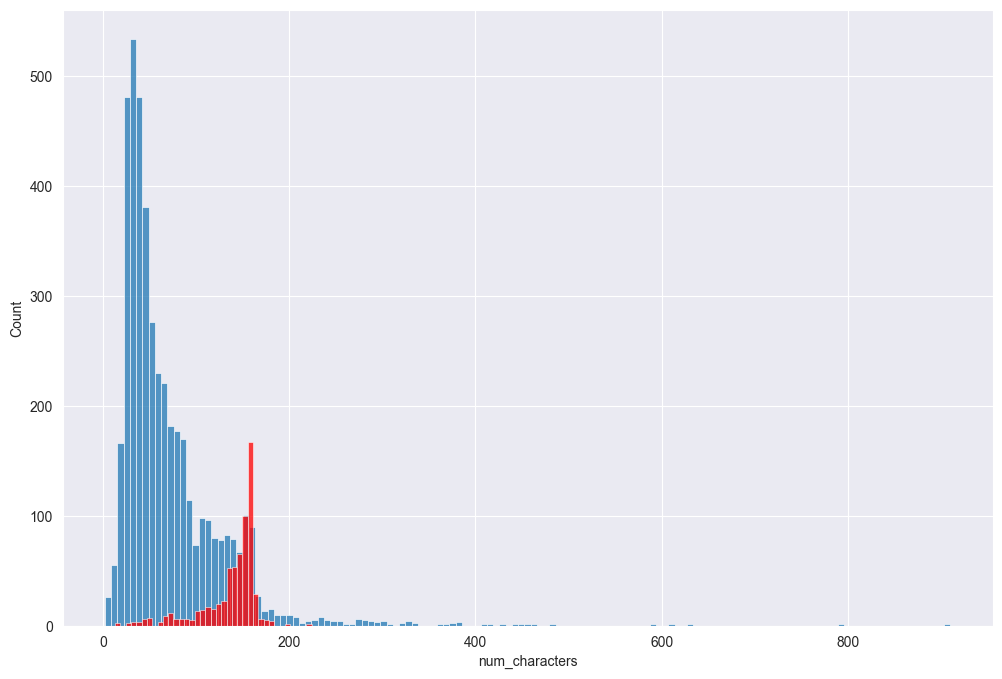

In [442]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='nums_words', ylabel='Count'>

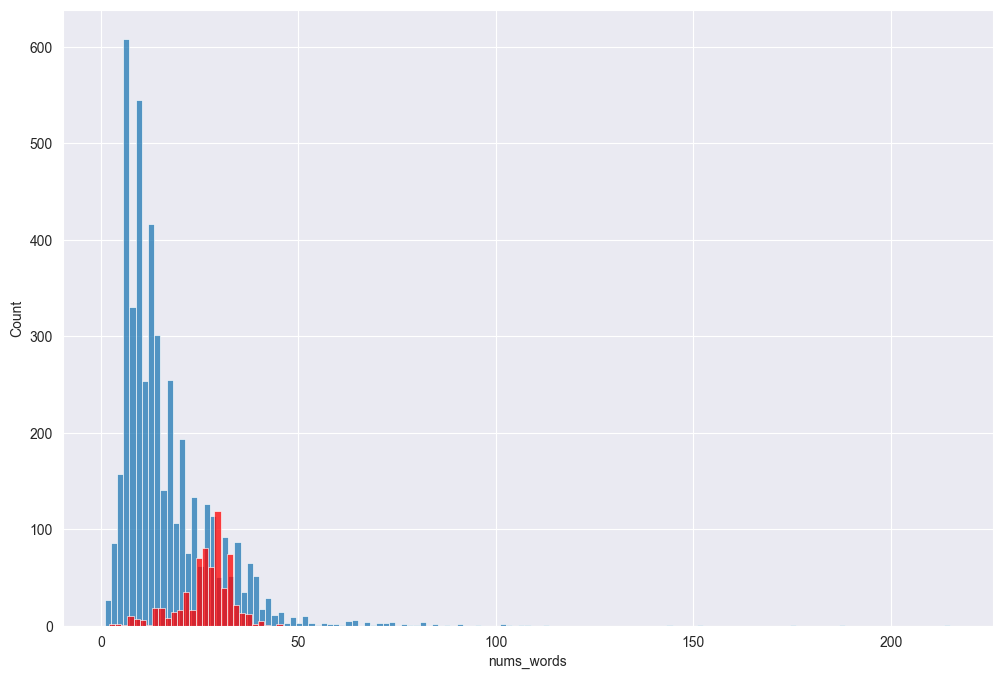

In [443]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['nums_words'])
sns.histplot(df[df['target'] == 1]['nums_words'], color='red')

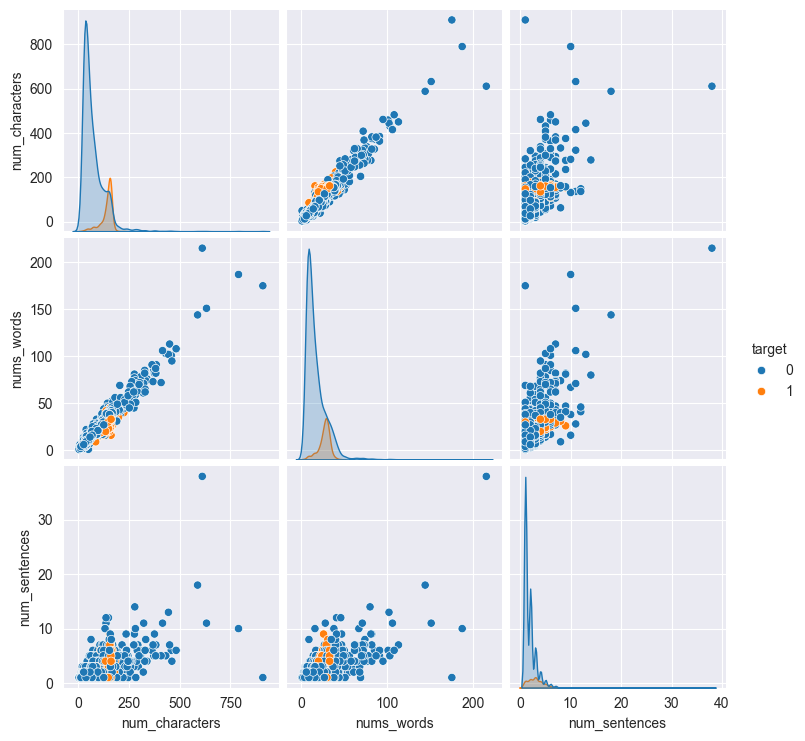

In [444]:
sns.pairplot(df, hue='target')

# 3. Data Preprocessing

In [445]:
import string
from nltk.corpus import stopwords

nltk.download('stopwords')

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text, language='english', preserve_line=True)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andriy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [446]:
#transform_text('Hi how are you Andrii?')

In [447]:
df['text'][1000]

'No..but heard abt tat..'

In [448]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

ps.stem('loving')

'love'

In [449]:
df['transformed_text'] = df['text'].apply(transform_text)

In [450]:
df.head()

,target,text,num_characters,nums_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [451]:
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [452]:
df['transformed_text'] = df['transformed_text'].fillna("").astype(str)


In [453]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

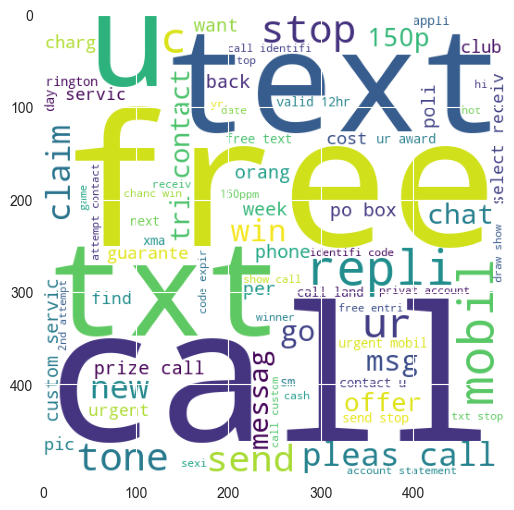

In [454]:
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)

In [455]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

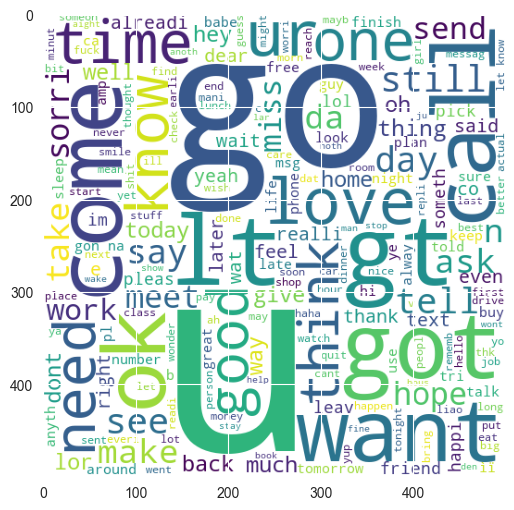

In [456]:
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)

In [457]:
df.head()

,target,text,num_characters,nums_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [458]:
spam_corpus = []

for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [459]:
len(spam_corpus)

9396

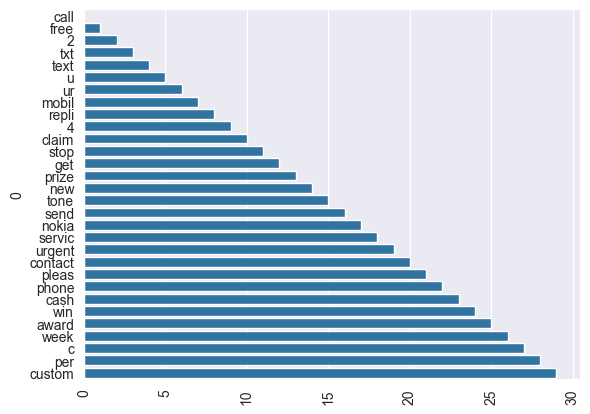

In [460]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0])
plt.xticks(rotation=90)
plt.show()

In [461]:
ham_corpus = []

for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [462]:
len(ham_corpus)

33638

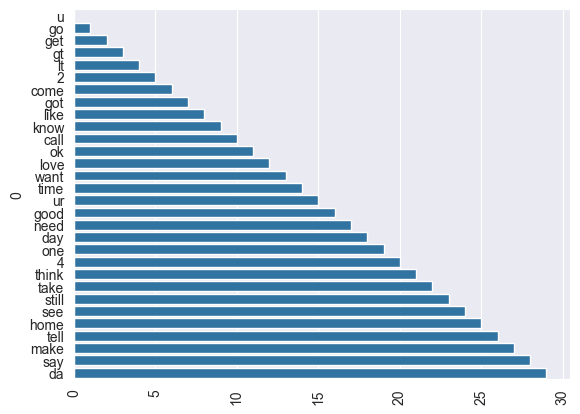

In [463]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0])
plt.xticks(rotation=90)
plt.show()

# 4. Model building and evaluating

In [464]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [465]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [466]:
X.shape

(5169, 6437)

In [467]:
y = df['target'].values

In [468]:
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

In [469]:
from sklearn.model_selection import train_test_split

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [471]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [472]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [473]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(confusion_matrix(y_test, y_pred_gnb))
print(precision_score(y_test, y_pred_gnb))

0.8626692456479691
[[780 116]
 [ 26 112]]
0.49122807017543857


In [474]:
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(precision_score(y_test, y_pred_mnb))

0.9555125725338491
[[896   0]
 [ 46  92]]
1.0


In [475]:
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred_bnb))
print(confusion_matrix(y_test, y_pred_bnb))
print(precision_score(y_test, y_pred_bnb))

0.971953578336557
[[892   4]
 [ 25 113]]
0.9658119658119658


In [476]:
# tfidf -> MNB

In [477]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [478]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)    

In [479]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB' : mnb,
    'DT' : dtc,
    'LR' : lrc,
    'RF' :rfc,
    'AdaBoost' : abc,
    'BgC' : bc,
    'ETC' : etc,
    'GBDT' : gbdt,
    'xgb' : xgb
}

In [480]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [481]:
train_classifier(svc, X_train, y_train, X_test, y_test)

(0.971953578336557, 0.9739130434782609)

In [482]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    
    current_accuracy, current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    
    print("For", name)
    print("Accuracy", current_accuracy)
    print("Precision", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    

For SVC
Accuracy 0.971953578336557
Precision 0.9739130434782609
For KN
Accuracy 0.8974854932301741
Precision 1.0
For NB
Accuracy 0.9555125725338491
Precision 1.0
For DT
Accuracy 0.9352030947775629
Precision 0.8256880733944955
For LR
Accuracy 0.9506769825918762
Precision 0.9484536082474226
For RF
Accuracy 0.9738878143133463
Precision 0.9826086956521739
For AdaBoost
Accuracy 0.9245647969052224
Precision 0.8658536585365854
For BgC
Accuracy 0.9613152804642167
Precision 0.8828125
For ETC
Accuracy 0.9729206963249516
Precision 0.9741379310344828
For GBDT
Accuracy 0.9506769825918762
Precision 0.8918918918918919
For xgb
Accuracy 0.9690522243713733
Precision 0.9344262295081968


In [483]:
print(clfs.keys())

performance_df = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Accuracy', ascending=False)

dict_keys(['SVC', 'KN', 'NB', 'DT', 'LR', 'RF', 'AdaBoost', 'BgC', 'ETC', 'GBDT', 'xgb'])


In [484]:
performance_df

,Algorithm,Accuracy,Precision
5,RF,0.973888,0.982609
8,ETC,0.972921,0.974138
0,SVC,0.971954,0.973913
10,xgb,0.969052,0.934426
7,BgC,0.961315,0.882812
2,NB,0.955513,1.000000
4,LR,0.950677,0.948454
9,GBDT,0.950677,0.891892
3,DT,0.935203,0.825688
6,AdaBoost,0.924565,0.865854


In [485]:
performance_df1 = pd.melt(performance_df, id_vars='Algorithm')

In [486]:
performance_df1

,Algorithm,variable,value
0,RF,Accuracy,0.973888
1,ETC,Accuracy,0.972921
2,SVC,Accuracy,0.971954
3,xgb,Accuracy,0.969052
4,BgC,Accuracy,0.961315
5,NB,Accuracy,0.955513
6,LR,Accuracy,0.950677
7,GBDT,Accuracy,0.950677
8,DT,Accuracy,0.935203
9,AdaBoost,Accuracy,0.924565


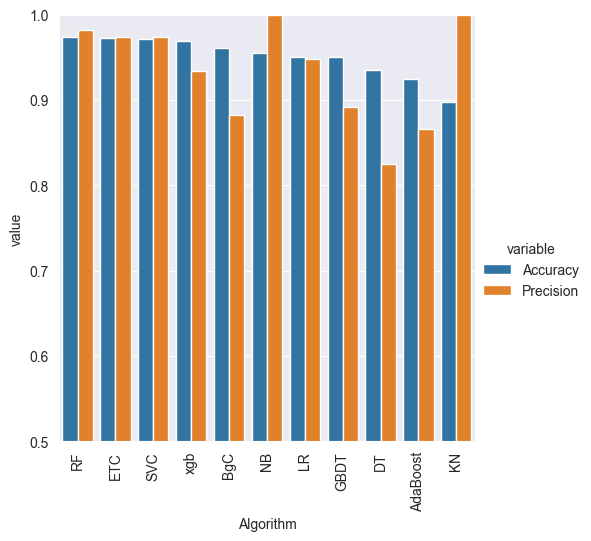

In [487]:
sns.catplot(x='Algorithm',y='value',hue='variable',data=performance_df1,kind='bar')

plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()

# 5. Improvement

# Change the max_features parameter of TfIdf

In [488]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy_max_ft_3000':accuracy_scores, 'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000', ascending=False)

In [489]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [490]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [491]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [492]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [493]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,RF,0.973888,0.982609,0.973888,0.982609,0.973888,0.982609,0.973888,0.982609
1,ETC,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138
2,SVC,0.971954,0.973913,0.971954,0.973913,0.971954,0.973913,0.971954,0.973913
3,xgb,0.969052,0.934426,0.969052,0.934426,0.969052,0.934426,0.969052,0.934426
4,BgC,0.961315,0.882812,0.961315,0.882812,0.961315,0.882812,0.961315,0.882812
5,NB,0.955513,1.000000,0.955513,1.000000,0.955513,1.000000,0.955513,1.000000
6,LR,0.950677,0.948454,0.950677,0.948454,0.950677,0.948454,0.950677,0.948454
7,GBDT,0.950677,0.891892,0.950677,0.891892,0.950677,0.891892,0.950677,0.891892
8,DT,0.935203,0.825688,0.935203,0.825688,0.935203,0.825688,0.935203,0.825688
9,AdaBoost,0.924565,0.865854,0.924565,0.865854,0.924565,0.865854,0.924565,0.865854


In [494]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [495]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [496]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [497]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9748549323017408
Precision 0.9912280701754386


In [498]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [499]:
from sklearn.ensemble import StackingClassifier

In [500]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [501]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9777562862669246
Precision 0.9389312977099237


In [502]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

# Testing

In [505]:
import  pickle

tfidf = pickle.load(open('vectorizer.pkl', 'rb'))
mnb = pickle.load(open('model.pkl', 'rb'))


new_text = ['Congratulations! You’ve won $1,000! Claim your prize now:']
vectorized_text = tfidf.transform(new_text)
prediction = mnb.predict(vectorized_text)

print("Клас", prediction[0])

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# 6. Website